In [ ]:
# //////////////////////////////////////// Imports
import numpy as np
import tensorflow as tf
import tensorflow_ranking as tfr
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
# //////////////////////////////////////// Load model and data
model_name = "v1_vacc_0.9585"
import_path = "./trained_models/{}".format(str(model_name))
model = tf.keras.models.load_model(import_path)

# //////////////////////////////////////// Load data
# You will need to unzip the respective batch folders.
# Obviously Batch_0 is not sufficient for testing as you will soon find out.
use_test_data = True # Set to false if other validation batch data is used
batch_nr = 2
if use_test_data:
    test_data_root = "./dataset/Test"
else:
    test_data_root = "./safetyBatches/Batch_" + str(batch_nr) + "/"
# train_data_root = "./dataset/Train/"
train_data_root = "./dataset/Train/"

batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(train_data_root)
# Get information on your train classes
train_class_names = np.array(train_ds.class_names)
print("Train Classes available: ", train_class_names)


# Import lables:
csv_path = test_data_root + '_label.csv'
df = pd.read_csv(filepath_or_buffer=csv_path, delimiter=',')
labels = df['ClassId'].tolist()

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=test_data_root + '/',
    labels=labels,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
)

files = test_ds.file_paths
# Get information on your val classes
class_names = np.array(test_ds.class_names)
print("Val Classes available: ", class_names)

if not use_test_data:
    # get the ground truth labels
    test_labels = np.concatenate([y for x, y in test_ds], axis=0)
    # Mapping test labels to the folder names instead of the index
    for i in range(0, len(test_labels)):
        test_labels[i] = int(class_names[test_labels[i]])
else:
    test_labels = labels

Found 29489 files belonging to 33 classes.
Train Classes available:  ['0' '1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20' '21'
 '22' '23' '24' '25' '26' '27' '28' '29' '3' '30' '31' '32' '33' '34' '35'
 '36' '37' '38']
Found 12630 files belonging to 1 classes.
Val Classes available:  ['00']


In [4]:
#/////////////////////////////////////// Prediction
# Remember that we had some preprocessing before our training this needs to be repeated here
# Preprocessing as the tensorflow hub models expect images as float inputs [0,1]
normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)
test_ds = test_ds.map(
    lambda x, y: (normalization_layer(x), y)
)  # Where x—images, y—labels.

# //////////////////////////////////////// Inference.
predictions = model.predict(test_ds)
predictions = np.argmax(predictions, axis=1)

# Mapping the prediction class id based on the folder names
for i in range(0, len(predictions)):
    predictions[i] = int(train_class_names[predictions[i]])

print("Predictions: ", predictions)
print("Ground truth: ", test_labels)

Predictions:  [16  1 38 ... 38  2 10]
Ground truth:  [16, 1, 38, 33, 11, 38, 18, 12, 25, 35, 12, 7, 23, 7, 4, 9, 21, 20, 27, 38, 4, 33, 9, 3, 1, 11, 13, 10, 9, 11, 5, 17, 34, 23, 2, 17, 3, 12, 16, 8, 7, 30, 18, 12, 24, 25, 3, 10, 18, 8, 25, 13, 15, 9, 13, 35, 5, 26, 9, 16, 38, 10, 4, 9, 15, 9, 26, 2, 5, 28, 11, 25, 30, 34, 5, 12, 1, 10, 25, 25, 21, 33, 25, 7, 10, 35, 3, 7, 22, 13, 3, 1, 2, 14, 12, 32, 3, 38, 9, 33, 1, 10, 5, 11, 33, 4, 35, 25, 33, 4, 1, 14, 16, 10, 30, 3, 27, 29, 1, 17, 13, 7, 1, 8, 2, 10, 10, 30, 1, 6, 36, 3, 14, 13, 11, 10, 18, 40, 2, 38, 41, 4, 6, 18, 17, 25, 2, 41, 11, 21, 7, 24, 11, 25, 17, 3, 6, 9, 7, 4, 13, 16, 4, 25, 18, 9, 13, 14, 29, 17, 13, 38, 26, 25, 33, 1, 3, 40, 13, 2, 8, 4, 36, 25, 20, 25, 18, 1, 10, 8, 10, 29, 12, 38, 31, 2, 8, 38, 18, 28, 17, 9, 4, 1, 17, 9, 2, 31, 13, 15, 15, 38, 25, 5, 25, 13, 10, 5, 4, 10, 2, 4, 5, 1, 14, 12, 12, 5, 8, 36, 25, 13, 33, 18, 33, 19, 12, 30, 4, 18, 12, 13, 20, 0, 10, 40, 5, 8, 12, 38, 20, 14, 0, 36, 34, 28, 35, 13, 25,

# Validation
## Metrics

In [6]:
#///////////////////////////////Validation
# Probably you will want to at least migrate these to another script or class when this grows..
def accuracy(predictions, test_labels):
    metric = tf.keras.metrics.Accuracy()
    metric.update_state(predictions, test_labels)
    return metric.result().numpy()

def mean_ap(pred, gt):
    metric = tfr.keras.metrics.MeanAveragePrecisionMetric()
    metric.update_state([gt], [pred])
    return metric.result().numpy()

print("Accuracy: ", accuracy(predictions, test_labels))
print("MAP: ", mean_ap(predictions, test_labels))

Accuracy:  0.6109264


ValueError: in user code:

    File "D:\05_GIt\DeepSafety\venv\lib\site-packages\tensorflow_ranking\python\keras\metrics.py", line 190, in update_state  *
        per_list_metric_val, per_list_metric_weights = self._metric.compute(
    File "D:\05_GIt\DeepSafety\venv\lib\site-packages\tensorflow_ranking\python\metrics_impl.py", line 289, in compute  *
        labels, predictions, weights, mask = self._prepare_and_validate_params(
    File "D:\05_GIt\DeepSafety\venv\lib\site-packages\tensorflow_ranking\python\metrics_impl.py", line 256, in _prepare_and_validate_params  *
        predictions.get_shape().assert_has_rank(2)

    ValueError: Shape (12630,) must have rank 2


## Plots

In [7]:
class_names_df = pd.read_csv("./signnames.csv", index_col="ClassId")
print(
    f'Class ID: {predictions[0]} Class Name: {class_names_df["SignName"][predictions[0]]}'
)

Class ID: 16 Class Name: Vehicles over 3.5 metric tons prohibited


In [8]:
def format_string2max(text, max_len):
    out_str = ""
    dif = 0
    for i, letter in enumerate(text):
        if ((i-dif) % max_len == 0) and (i != 0):
            out_str += '\n'
        out_str += letter
        if letter == '\n':
            dif += i
    return out_str

C:\Users\manue\AppData\Local\Temp\ipykernel_3776\1777978288.py:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(num_cells, num_cells, i + 1)


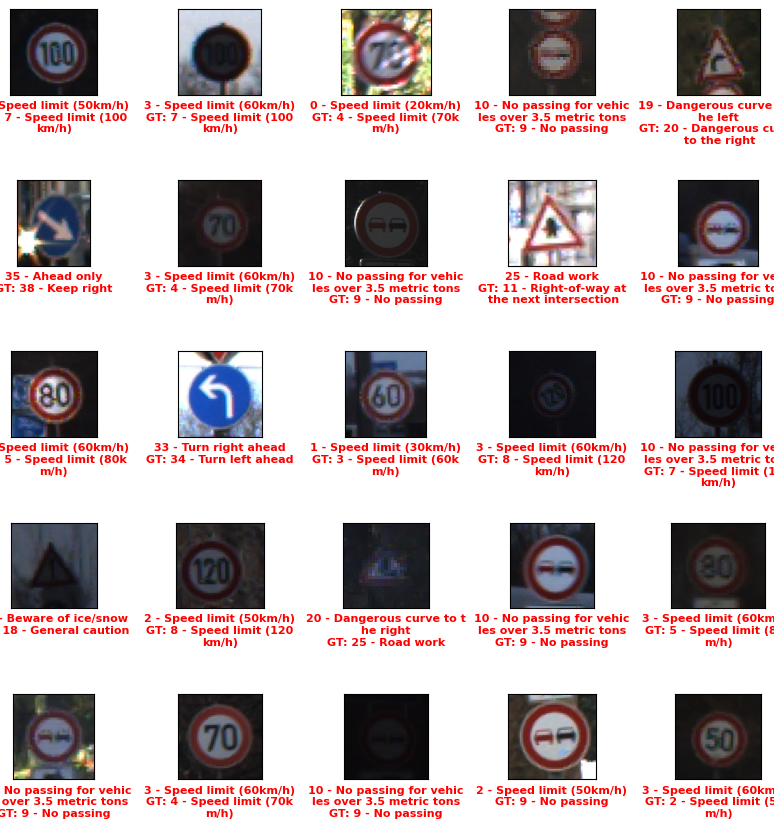

In [13]:
# Show wrongly classified data
idx_wrong_class = [i for i in range(0, len(predictions)) if predictions[i] != test_labels[i]]

# cut to0 much data
num_cut = 25
if len(idx_wrong_class)>=num_cut:
    idx_wrong_class_cut = idx_wrong_class[:num_cut]
else:
    idx_wrong_class_cut = idx_wrong_class
numbers_to_display = len(idx_wrong_class_cut)
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(10, 10))

for i in range(0, len(idx_wrong_class_cut)):
    idx = idx_wrong_class_cut[i]
    predicted_label = f'{predictions[idx]} - {class_names_df["SignName"][predictions[idx]]}\n' \
                      f'GT: {test_labels[idx]} - {class_names_df["SignName"][test_labels[idx]]}'
    predicted_label = format_string2max(predicted_label, 25)
    plt.grid(False)
    # color_map = 'Greens' if predictions[idx] == test_labels[idx] else 'Reds'
    # plt.set_cmap(color_map)
    plt.subplot(num_cells, num_cells, i + 1)
    img = mpimg.imread(files[idx])
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    font = {'color': 'green', 'weight': 'normal', 'size': 8} if predictions[idx] == test_labels[idx] \
        else {'color': 'red', 'weight': 'bold', 'size': 8}
    plt.xlabel(predicted_label,  fontdict=font)

plt.subplots_adjust(hspace=1, wspace=0.5)
plt.show()

In [33]:
# Plot error matrix
num_cls = len(class_names_df)
error_matrix_df = pd.DataFrame(np.zeros((num_cls, num_cls)))
# print(error_matrix_df)
for i in range(0, len(idx_wrong_class)):
    idx = idx_wrong_class[i]
    error_matrix_df.loc[test_labels[idx], predictions[idx]] = error_matrix_df.loc[test_labels[idx], predictions[idx]] + 1
error_matrix_df.columns = class_names_df["SignName"].tolist()
error_matrix_df.index = class_names_df["SignName"].tolist()

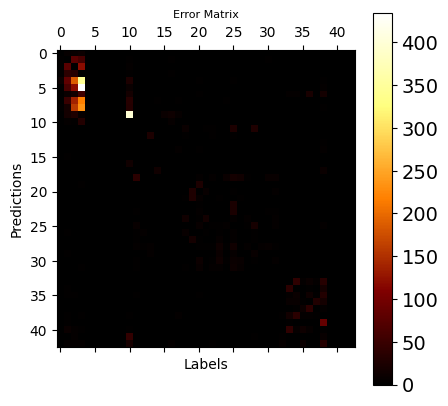

Max error count:435.0 Min error count: 0.0


In [48]:
# print(error_matrix_df)
# rescale for better visualisation
plt.matshow(error_matrix_df, cmap='afmhot')
# plt.xticks(class_names_df["SignName"].tolist(), fontsize=14, rotation=90)
# plt.yticks(class_names_df["SignName"].tolist(), fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Error Matrix', fontsize=8);
plt.ylabel('Predictions')
plt.xlabel('Labels')
plt.show()
print("Max error count:" + str(error_matrix_df.max().max()) + " Min error count: " + str(error_matrix_df.min().min()))